In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from llama import get_model_and_tokenizer
from data.serialize import serialize_arr, deserialize_str, SerializerSettings

from rl_utils import serialize_gaussian, icl_prediction

In [2]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
tokenizer.pad_token_id = tokenizer.eos_token_id

endoso = "Se cubre(n): Todas las cesÃ¡reas en la vida de La Asegurada_Son elegibles para esta cobertura:_- La Asegurada titular__Bajo las coberturas arriba seÃ±aladas y sujeto a lo siguiente:__Quedan cubiertos los gastos ocasionados exclusivamente por la cesÃ¡rea, por:_- Honorarios de mÃ©dicos que participaron en la atenciÃ³n de la cirugÃ­a._- Gastos de hospitalizaciÃ³n._- Medicamentos necesarios para la recuperaciÃ³n dentro del hospital.__El monto a indemnizar para este beneficio y/o cobertura serÃ¡:_De acuerdo a lo siguiente: Monto MÃ¡ximo a Indemnizar 35,000.00 M.N.__Pago Directo (MÃ©dico y Hospital en convenio de acuerdo al nivel_hospitalario contratado)_Deducible 0.00 M.N._Coaseguro 0.00 %_Reembolso:_Deducible 0.00 M.N._Coaseguro 0.00 %_En caso de modificaciÃ³n del deducible y/o coaseguro originalmente pactado,_invariablemente se aplicarÃ¡n los deducibles y coaseguros antes mencionados_en dicha cobertura/condiciÃ³n.__Quedan excluidos todos aquellos gastos derivados del control o seguimiento_durante el embarazo, asÃ­ como aquellos gastos posteriores al parto.__Para este beneficio y/o cobertura la madre deberÃ¡ cumplir con un periodo_de espera de: Sin periodo de espera.__Se cubre Ãºnicamente en territorio nacional.__Los demÃ¡s tÃ©rminos y condiciones, deben operar conforme se seÃ±ala en las_Condiciones Generales del producto contratado para esta cobertura.__Este endoso forma parte integral y complementa las Condiciones Generales_del Seguro.__"
prompt = "What are the parameters of this guarantee? " + endoso

inputs = tokenizer([prompt], return_tensors="pt")

outputs = model.generate(
    **inputs,
    max_new_tokens=50,
    num_beams=4,
    num_return_sequences=4,
    return_dict_in_generate=True,
    output_scores=True,
)

transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False
)

generated_tokens = outputs.sequences[:, inputs.input_ids.shape[1]:]

for tok, score in zip(generated_tokens[0], transition_scores[0]):
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/home/abenechehab/miniforge3/envs/LLMICL/lib/python3.9/site-packages/transformers/generation/utils.py:1460: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


|  1542 | Se       | -4.943 | 0.71%
| 19250 |  cub     | -3.745 | 2.36%
|   265 | re       | -0.489 | 61.33%
|  1471 | (n       | -1.449 | 23.49%
|  1680 | ):       | -0.119 | 88.75%
| 59683 |  Tod     | -0.586 | 55.68%
|   300 | as       | -0.001 | 99.92%
|  5252 |  las     | -0.014 | 98.62%
| 27750 |  ces     | -0.144 | 86.62%
| 19321 | Ã        | -0.022 | 97.83%
| 40932 | ¡        | -0.009 | 99.11%
| 51518 | reas     | -0.010 | 99.00%
|   665 |  en      | -0.049 | 95.19%
|  1208 |  la      | -0.013 | 98.70%
| 25994 |  vida    | -0.003 | 99.70%
|   409 |  de      | -0.009 | 99.14%
|  5034 |  La      | -0.071 | 93.11%
|   362 |  A       | -0.009 | 99.11%
| 14949 | seg      | -0.000 | 99.96%
|   324 | ur       | -0.000 | 99.99%
|  2649 | ada      | -0.005 | 99.53%
|  1117 | _S       | -0.243 | 78.41%
|   263 | on       | -0.001 | 99.86%
| 18190 |  eleg    | -0.007 | 99.28%
| 21041 | ibles    | -0.001 | 99.88%
|  3429 |  para    | -0.001 | 99.92%
| 15491 |  esta    | -0.003 | 99.66%
| 3

In [1]:
import transformers
import torch
pipeline = transformers.pipeline("text-generation", model="/data01/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/c4a54320a52ed5f88b7a2f84496903ea4ff07b45/", model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
endoso = "Se cubre(n): Todas las cesÃ¡reas en la vida de La Asegurada_Son elegibles para esta cobertura:_- La Asegurada titular__Bajo las coberturas arriba seÃ±aladas y sujeto a lo siguiente:__Quedan cubiertos los gastos ocasionados exclusivamente por la cesÃ¡rea, por:_- Honorarios de mÃ©dicos que participaron en la atenciÃ³n de la cirugÃ­a._- Gastos de hospitalizaciÃ³n._- Medicamentos necesarios para la recuperaciÃ³n dentro del hospital.__El monto a indemnizar para este beneficio y/o cobertura serÃ¡:_De acuerdo a lo siguiente: Monto MÃ¡ximo a Indemnizar 35,000.00 M.N.__Pago Directo (MÃ©dico y Hospital en convenio de acuerdo al nivel_hospitalario contratado)_Deducible 0.00 M.N._Coaseguro 0.00 %_Reembolso:_Deducible 0.00 M.N._Coaseguro 0.00 %_En caso de modificaciÃ³n del deducible y/o coaseguro originalmente pactado,_invariablemente se aplicarÃ¡n los deducibles y coaseguros antes mencionados_en dicha cobertura/condiciÃ³n.__Quedan excluidos todos aquellos gastos derivados del control o seguimiento_durante el embarazo, asÃ­ como aquellos gastos posteriores al parto.__Para este beneficio y/o cobertura la madre deberÃ¡ cumplir con un periodo_de espera de: Sin periodo de espera.__Se cubre Ãºnicamente en territorio nacional.__Los demÃ¡s tÃ©rminos y condiciones, deben operar conforme se seÃ±ala en las_Condiciones Generales del producto contratado para esta cobertura.__Este endoso forma parte integral y complementa las Condiciones Generales_del Seguro.__"
prompt = "What are the parameters of this guarantee? " + endoso
pipeline(prompt)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': 'What are the parameters of this guarantee? Se cubre(n): Todas las cesÃ¡reas en la vida de La Asegurada_Son elegibles para esta cobertura:_- La Asegurada titular__Bajo las coberturas arriba seÃ±aladas y sujeto a lo siguiente:__Quedan cubiertos los gastos ocasionados exclusivamente por la cesÃ¡rea, por:_- Honorarios de mÃ©dicos que participaron en la atenciÃ³n de la cirugÃ\xada._- Gastos de hospitalizaciÃ³n._- Medicamentos necesarios para la recuperaciÃ³n dentro del hospital.__El monto a indemnizar para este beneficio y/o cobertura serÃ¡:_De acuerdo a lo siguiente: Monto MÃ¡ximo a Indemnizar 35,000.00 M.N.__Pago Directo (MÃ©dico y Hospital en convenio de acuerdo al nivel_hospitalario contratado)_Deducible 0.00 M.N._Coaseguro 0.00 %_Reembolso:_Deducible 0.00 M.N._Coaseguro 0.00 %_En caso de modificaciÃ³n del deducible y/o coaseguro originalmente pactado,_invariablemente se aplicarÃ¡n los deducibles y coaseguros antes mencionados_en dicha cobertura/condiciÃ³n.__Quedan 

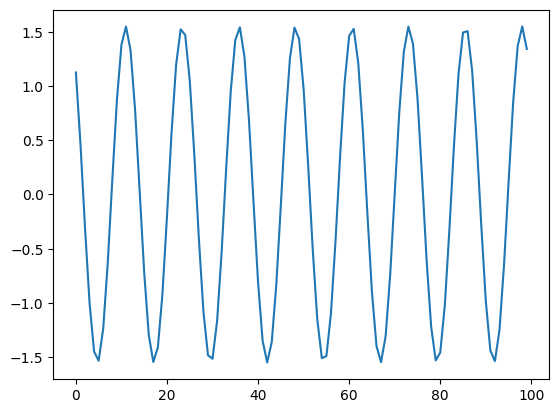

In [36]:
time_series = []

s0 = 1.5
s1 = 1.5
alpha = 1.0
beta = 1.0
Deltat = .5
for _ in range(100):
    update = (2 - Deltat**2) * s1 - s0
    time_series.append(update)
    s0 = s1
    s1 = update

time_series = np.array(time_series)
mean_series = copy.copy(time_series)
std_series = np.zeros_like(mean_series)

plt.plot(time_series)

In [33]:
full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(2, time_series, mean_series, std_series)

print(f"full_series: {full_series[:10]}")

# Save the generated data to a dictionary
series_dict = {
    'full_series': full_series,
    'rescaled_true_mean_arr': rescaled_true_mean_arr,
    'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
    'time_series': np.array(time_series)
}

full_series: 754,605,43


In [34]:
save_path = Path(parent_dir) / 'non_markovian'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [35]:
# -------------------- ICL prediction using llama3 --------------------
series_dict = icl_prediction(
    model=model, 
    tokenizer=tokenizer, 
    series_dict=series_dict, 
    temperature=0.5, 
    save=True,
    save_path=str(os.path.join(save_path, f"pendulum.pkl"))
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6879.99it/s]
